<h2>Load Libraries</h2>

In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import csv
from datetime import datetime, timedelta
from statistics import mean
import numpy as np
import darts

from dateutil.tz import tzutc
from dateutil.parser import parse

def date_utc(s):
    return parse(s, tzinfos=tzutc)


<h2>Read CSV and Resample</h2>

In [126]:
df = pd.read_csv('Raspberry/anujrachel/netmeter.csv',
                 sep = ';',usecols = ["Date","Valeur"], parse_dates =["Date"], index_col ="Date")
power = pd.DataFrame()
power["power"] = df.resample('1H').mean().interpolate()
power = power.tz_localize('UTC')


df = pd.read_csv('Raspberry/anujrachel/Temperature.csv', parse_dates =["time"], index_col ="time")
temperature = pd.DataFrame()
temperature["temperature"] = df.resample('1H').mean().interpolate()


df = pd.read_csv('Raspberry/anujrachel/Humidity.csv', parse_dates =["time"], index_col ="time")
humidity = pd.DataFrame()
humidity["humidity"] = df.resample('1H').mean().interpolate()


df = pd.read_csv('Raspberry/anujrachel/rain.csv', parse_dates =["time"], index_col ="time")
rain = pd.DataFrame()
rain["rain"] = df.resample('1H').mean().interpolate()


df = pd.read_csv('Raspberry/anujrachel/UV.csv', parse_dates =["time"], index_col ="time")
UV = pd.DataFrame()
UV["UV"] = df.resample('1H').mean().interpolate()


df = pd.read_csv('Raspberry/anujrachel/wind.csv', parse_dates =["time"], index_col ="time")
wind = pd.DataFrame()
wind["wind"] = df.resample('1H').mean().interpolate()


df = pd.read_csv('Raspberry/anujrachel/lux.csv', parse_dates =["time"], index_col ="time")
lux = pd.DataFrame()
lux["lux"] = df.resample('1H').mean().interpolate()

<h2>Concat the data</h2>

In [129]:
inputdata = pd.concat([power, temperature, humidity, rain, UV, wind, lux], axis = 1, join = "inner")
inputdata

,power,temperature,humidity,rain,UV,wind,lux
2022-01-11 16:00:00+00:00,372.519444,4.150000,56.500000,0.000000,0.005000,3.000000,47.588462
2022-01-11 17:00:00+00:00,470.152778,3.300000,62.666667,0.000000,0.007667,2.400000,44.501883
2022-01-11 18:00:00+00:00,961.711111,2.700000,68.000000,0.000000,0.010333,3.500000,41.415305
2022-01-11 19:00:00+00:00,623.163889,2.450000,70.500000,0.000000,0.013000,2.200000,38.328726
2022-01-11 20:00:00+00:00,420.194444,2.500000,71.200000,0.000000,0.015667,2.714286,35.242148
...,...,...,...,...,...,...,...
2022-12-30 19:00:00+00:00,430.924901,11.445455,77.500000,0.060600,0.060875,5.428571,13.600459
2022-12-30 20:00:00+00:00,371.473310,10.770588,82.909091,0.028857,0.062260,6.000000,13.102445
2022-12-30 21:00:00+00:00,302.598007,11.390000,77.500000,0.000000,0.063646,5.666667,12.604431
2022-12-30 22:00:00+00:00,324.187279,10.850000,81.500000,0.000000,0.065031,4.833333,12.106418


In [132]:
inputdata.to_csv("inputdata.csv")

In [133]:
profile = ProfileReport(inputdata, tsmode=True)
profile.to_file('inputdata_report.html')

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

<h2>Correlation Heatmap</h2>

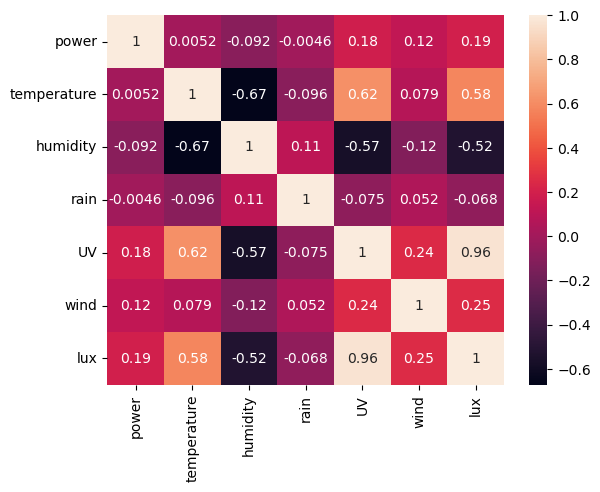

In [136]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_mat = inputdata.corr()
sns.heatmap(correlation_mat, annot = True)
plt.show()

In [5]:
df = pd.read_csv('Raspberry/anujrachel/netmeter.csv',
                 sep = ';',usecols = ["Date","Valeur"], parse_dates =["Date"], index_col ="Date")
power = pd.DataFrame()
power["power"] = df.resample('1H').mean().interpolate()

power["date"] = power.index
power

from darts import TimeSeries
series = TimeSeries.from_dataframe(power, 'date', 'power')

<h2>Import Darts Libraries</h2>

In [12]:
from darts.models import RNNModel, ExponentialSmoothing, BlockRNNModel, NBEATSModel
from darts.dataprocessing.transformers import Scaler, MissingValuesFiller
from darts.metrics import mape, r2_score,mae
from darts.utils.statistics import check_seasonality, plot_acf
from darts.datasets import AirPassengersDataset, SunspotsDataset
from darts.utils.timeseries_generation import datetime_attribute_timeseries
from darts.models import TCNModel

import warnings

warnings.filterwarnings("ignore")
import logging

logging.disable(logging.CRITICAL)

In [7]:
train, val = series.split_after(pd.Timestamp("20221111"))
transformer = Scaler()
train_transformed = transformer.fit_transform(train)
val_transformed = transformer.transform(val)
series_transformed = transformer.transform(series)

In [8]:
def display_forecast(pred_series, ts_transformed, forecast_type, start_date=None):
    plt.figure(figsize=(8, 5))
    if start_date:
        ts_transformed = ts_transformed.drop_before(start_date)
    ts_transformed.univariate_component(0).plot(label="actual")
    pred_series.plot(label=("historic " + forecast_type + " forecasts"))
    plt.title(
        "MAE: {}".format(mae(ts_transformed.univariate_component(0), pred_series))
    )
    plt.legend()

In [9]:
df = power
df

,power,date
Date,,
2022-01-01 00:00:00,278.866667,2022-01-01 00:00:00
2022-01-01 01:00:00,228.375000,2022-01-01 01:00:00
2022-01-01 02:00:00,260.225000,2022-01-01 02:00:00
2022-01-01 03:00:00,222.072222,2022-01-01 03:00:00
2022-01-01 04:00:00,259.430556,2022-01-01 04:00:00
...,...,...
2022-12-30 19:00:00,430.924901,2022-12-30 19:00:00
2022-12-30 20:00:00,371.473310,2022-12-30 20:00:00
2022-12-30 21:00:00,302.598007,2022-12-30 21:00:00


<h2>Plot the Normalised Hourly Data</h2>

Text(0.5, 1.0, 'Daily electricity consumption')

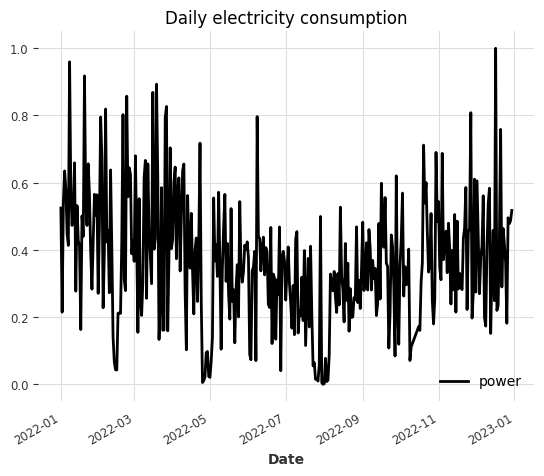

In [10]:
df_day_avg = df.groupby(df.index.astype(str).str.split(" ").str[0]).mean().reset_index()
filler = MissingValuesFiller()
scaler = Scaler()
series = scaler.fit_transform(
    filler.transform(
        TimeSeries.from_dataframe(
            df_day_avg, "Date", ["power"]
        )
    )
).astype(np.float32)
series.plot()
plt.title("Daily electricity consumption")

<h2>Test Train Split</h2>

In [11]:
train, val = series.split_after(pd.Timestamp("20221111"))

<h2>TCN Model</h2>

In [12]:
model_en = TCNModel(
    input_chunk_length=7,
    output_chunk_length=1,
    n_epochs=50,
    dropout=0.2,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0,
)

In [13]:
model_en.fit(series=train, verbose=True)

Training: 0it [00:00, ?it/s]

  0%|          | 0/110 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

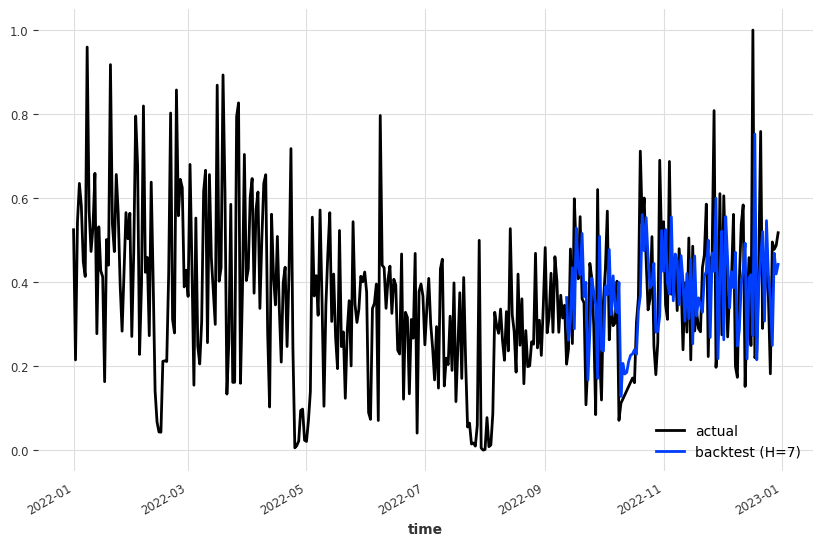

In [14]:
backtest_en = model_en.historical_forecasts(
    series=series,
    start=0.7,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True,
)

plt.figure(figsize=(10, 6))
series.plot(label="actual")
backtest_en.plot(label="backtest (H=7)")
plt.legend()

<h3>Evaluate</h3>

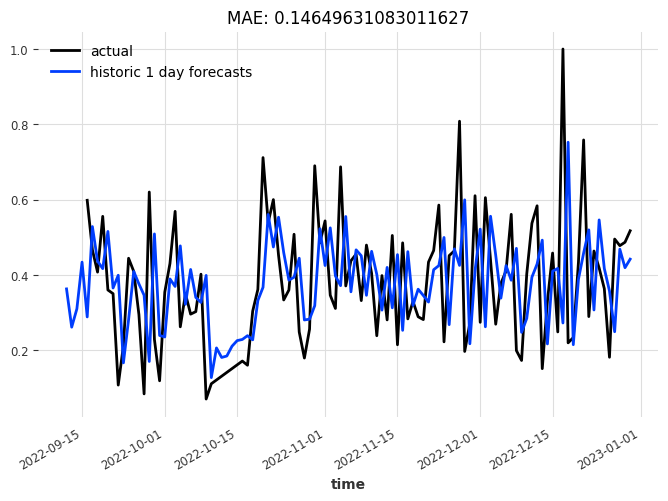

In [17]:
display_forecast(backtest_en , series, "1 day", start_date=pd.Timestamp("20220915"))

<h2>TCN Model with Hourly Data Input</h2>

Text(0.5, 1.0, 'Hourly electricity consumption')

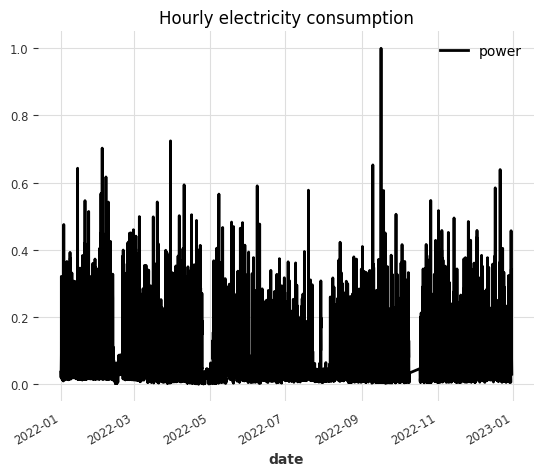

In [9]:
series_transformed.plot()
plt.title("Hourly electricity consumption")

In [10]:
train, val = series_transformed.split_after(pd.Timestamp("20221111"))

In [13]:
model_h = TCNModel(
    input_chunk_length=7*24,
    output_chunk_length=1,
    n_epochs=50,
    dropout=0.2,
    dilation_base=2,
    weight_norm=True,
    kernel_size=5,
    num_filters=8,
    nr_epochs_val_period=1,
    random_state=0,
)

In [14]:
model_h.fit(series=train, verbose=True)

Training: 0it [00:00, ?it/s]

In [15]:
backtest_h = model_h.historical_forecasts(
    series=series_transformed,
    start=0.7,
    forecast_horizon=1,
    stride=1,
    retrain=False,
    verbose=True,
)

  0%|          | 0/2622 [00:00<?, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

Predicting: 0it [00:00, ?it/s]

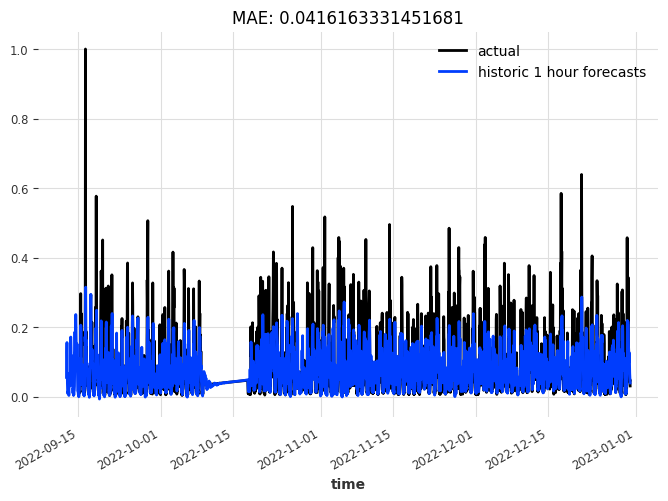

In [18]:
display_forecast(backtest_h , series_transformed, "1 hour", start_date=pd.Timestamp("20220915"))

In [20]:
model_h